In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

from utils import *
from drawer import *

In [2]:
# the ration between number of clusters and classes
clusters_per_class = 1.5
# the mapping from layer names to the corresponding gate weights indices
layer2idx = {
    'Conv1': (0, 64),
    'Conv10': (64, 576),
    'Conv11': (576, 1088),
    'Conv12': (1088, 1600),
    'Conv13': (1600, 2112),
    'Conv2': (2112, 2176),
    'Conv3': (2176, 2304),
    'Conv4': (2304, 2432),
    'Conv5': (2432, 2688),
    'Conv6': (2688, 2944),
    'Conv7': (2944, 3200),
    'Conv8': (3200, 3712),
    'Conv9': (3712, 4224),
    'FC14': (4224, 8320),
    'FC15': (8320, 12416)
}

## CDRP Clustering of Cifar-5 on VGG Trained on Cifar-100
- cifar-5 refers to the first 5 classes in the cifar-100, which is 5 * 500 = 2500 samples
- also we only analyze the gate weights for convolutional layers

In [3]:
data = np.loadtxt('data/cifar-5/data.txt')
labels = np.loadtxt('data/cifar-5/labels.txt')
classes = np.unique(labels)
data.shape, labels.shape, classes.shape

((2500, 4224), (2500,), (5,))

In [4]:
kmeans = KMeans(n_clusters=int(len(classes)*clusters_per_class), random_state=0, n_jobs=-1, verbose=0).fit(data)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
centers = pca.transform(kmeans.cluster_centers_)
data_pca.shape, centers.shape

((2500, 2), (7, 2))

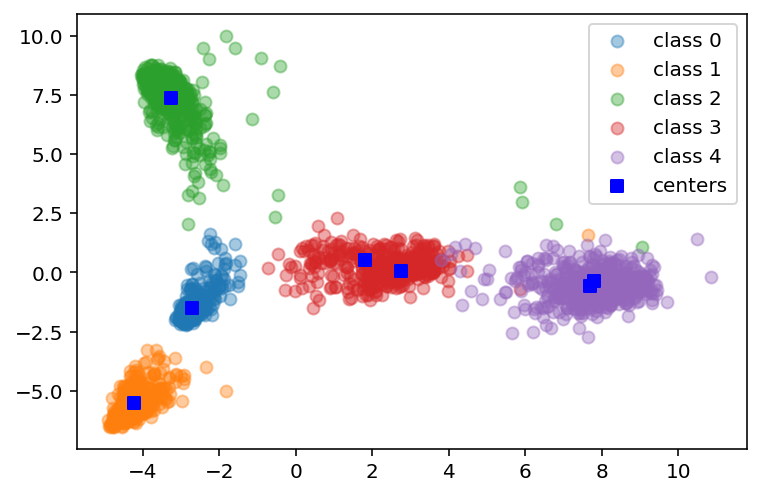

In [5]:
%config InlineBackend.figure_format = 'retina'
for label in classes:
    mask = (labels == label)
    plt.scatter(data_pca[mask, 0], data_pca[mask, 1], alpha=0.4, label="class " + str(int(label)))
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label='centers', c='b')
plt.legend()

The PCA visualization of all samples and cluster centers is shown in the figure above.
The result is quite pleasing because all classes can be separated in the first 2 principal dimensions.

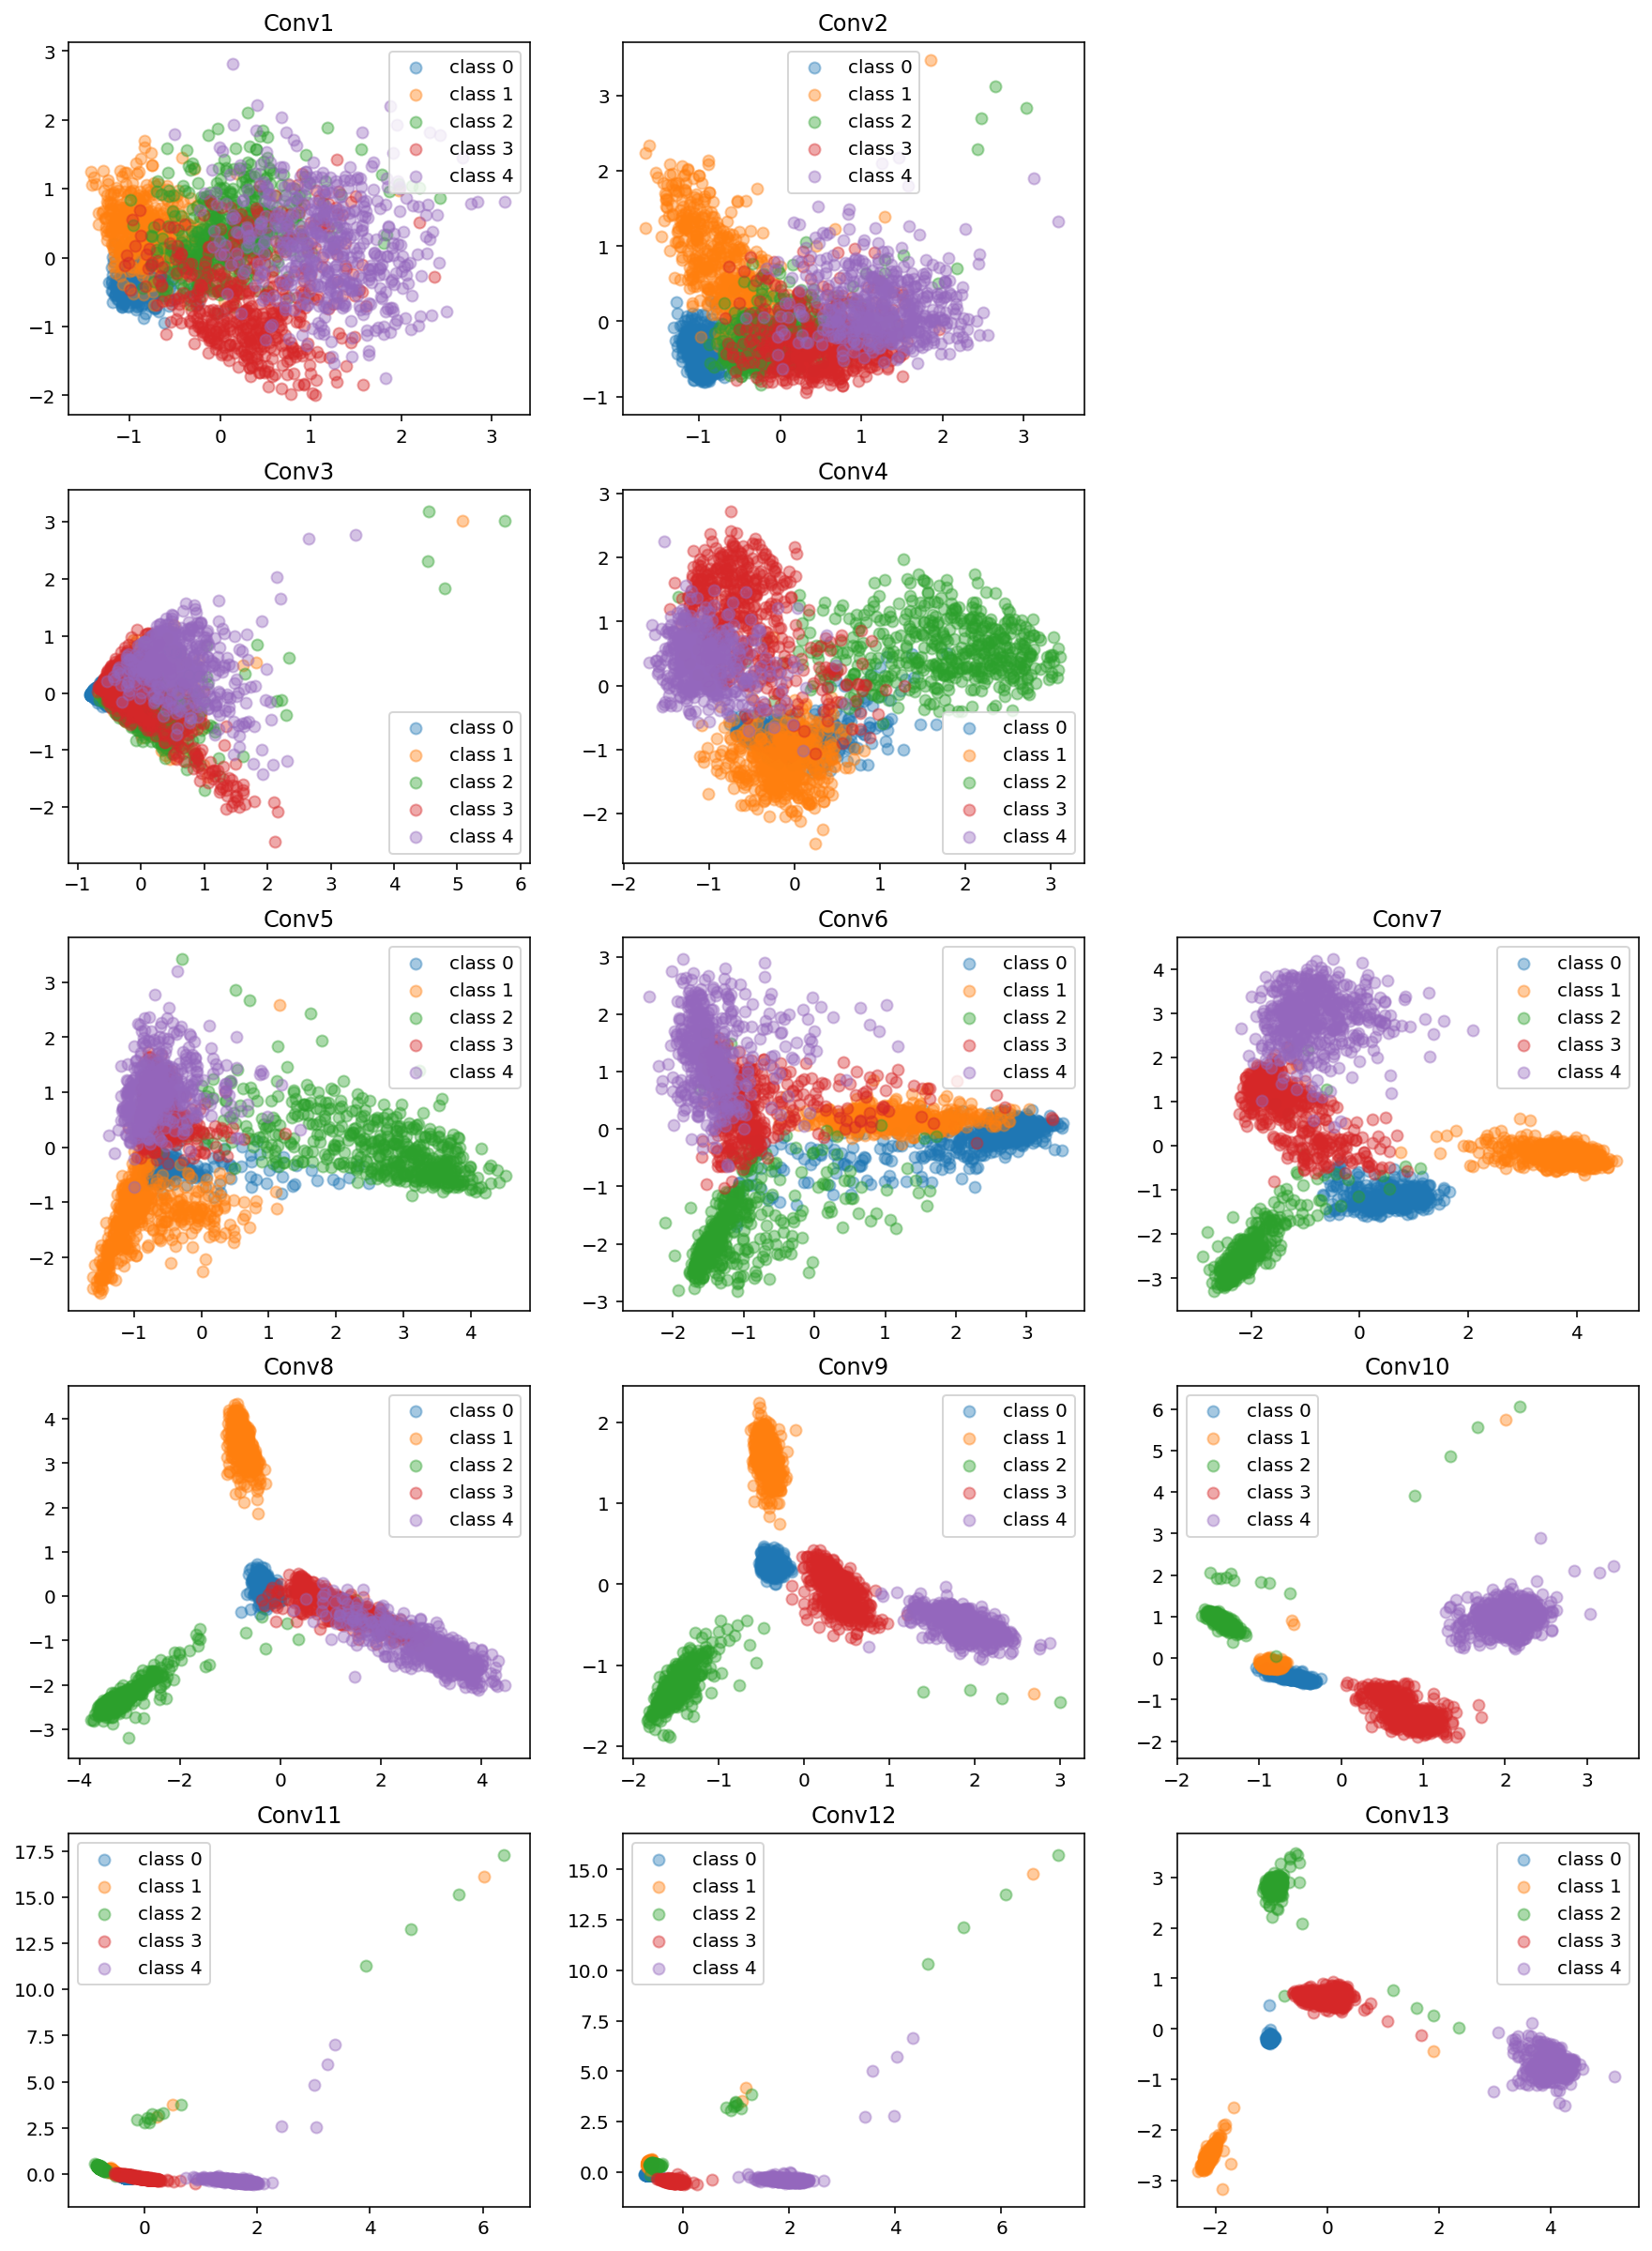

In [6]:
mapping = [1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.figure(figsize=(15, 5*6))
for i in range(1, 14):
    plt.subplot(7, 3, mapping[i-1])
    layer = "Conv{}".format(i)
    idx = layer2idx[layer]
    X = data[:, idx[0]:idx[1]]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    for label in classes:
        mask = (labels == label)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                alpha=0.4, label="class " + str(int(label)))
    plt.title(layer)
    plt.legend()

Above is the result of visualizing samples based only on gate weights in each convolutional layer.

## CDRP Clustering of Cifar-5 on VGG Trained on Imagenet-1000
- for each sample in Cifar-5, we train gates in a VGGNet trained on Imagenet-1000 to extract CDRP models in it and use the $\Lambda$ weights as a feature of the sample to perform the clustering
- the vggNet trained on imagenet has slightly different structure from the one trained on cifar-100
    - input shape (244, 244)
    - output shape (1000,)
    - different convolution kernel size

In [7]:
data = np.loadtxt('data/imagenet-5/data.txt')
labels = np.loadtxt('data/imagenet-5/labels.txt')
classes = np.unique(labels)
data.shape, labels.shape, classes.shape

((2500, 4224), (2500,), (5,))

In [8]:
kmeans = KMeans(n_clusters=int(len(classes)*clusters_per_class), random_state=0, n_jobs=-1, verbose=0).fit(data)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
centers = pca.transform(kmeans.cluster_centers_)
data_pca.shape, centers.shape

((2500, 2), (7, 2))

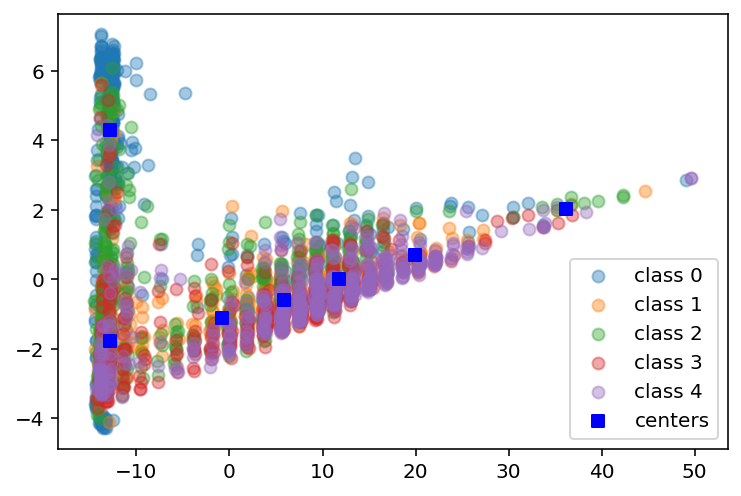

In [9]:
%config InlineBackend.figure_format = 'retina'
for label in classes:
    mask = (labels == label)
    plt.scatter(data_pca[mask, 0], data_pca[mask, 1], alpha=0.4, label="class " + str(int(label)))
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label='centers', c='b')
plt.legend()

Above is the PCA visualization of clustering result.
We observe that the samples can not be separated very well.
Although there are some rules on the distribution of the samples, like no purple ones on the upper-left corner, we are not sure this can be meaningful.

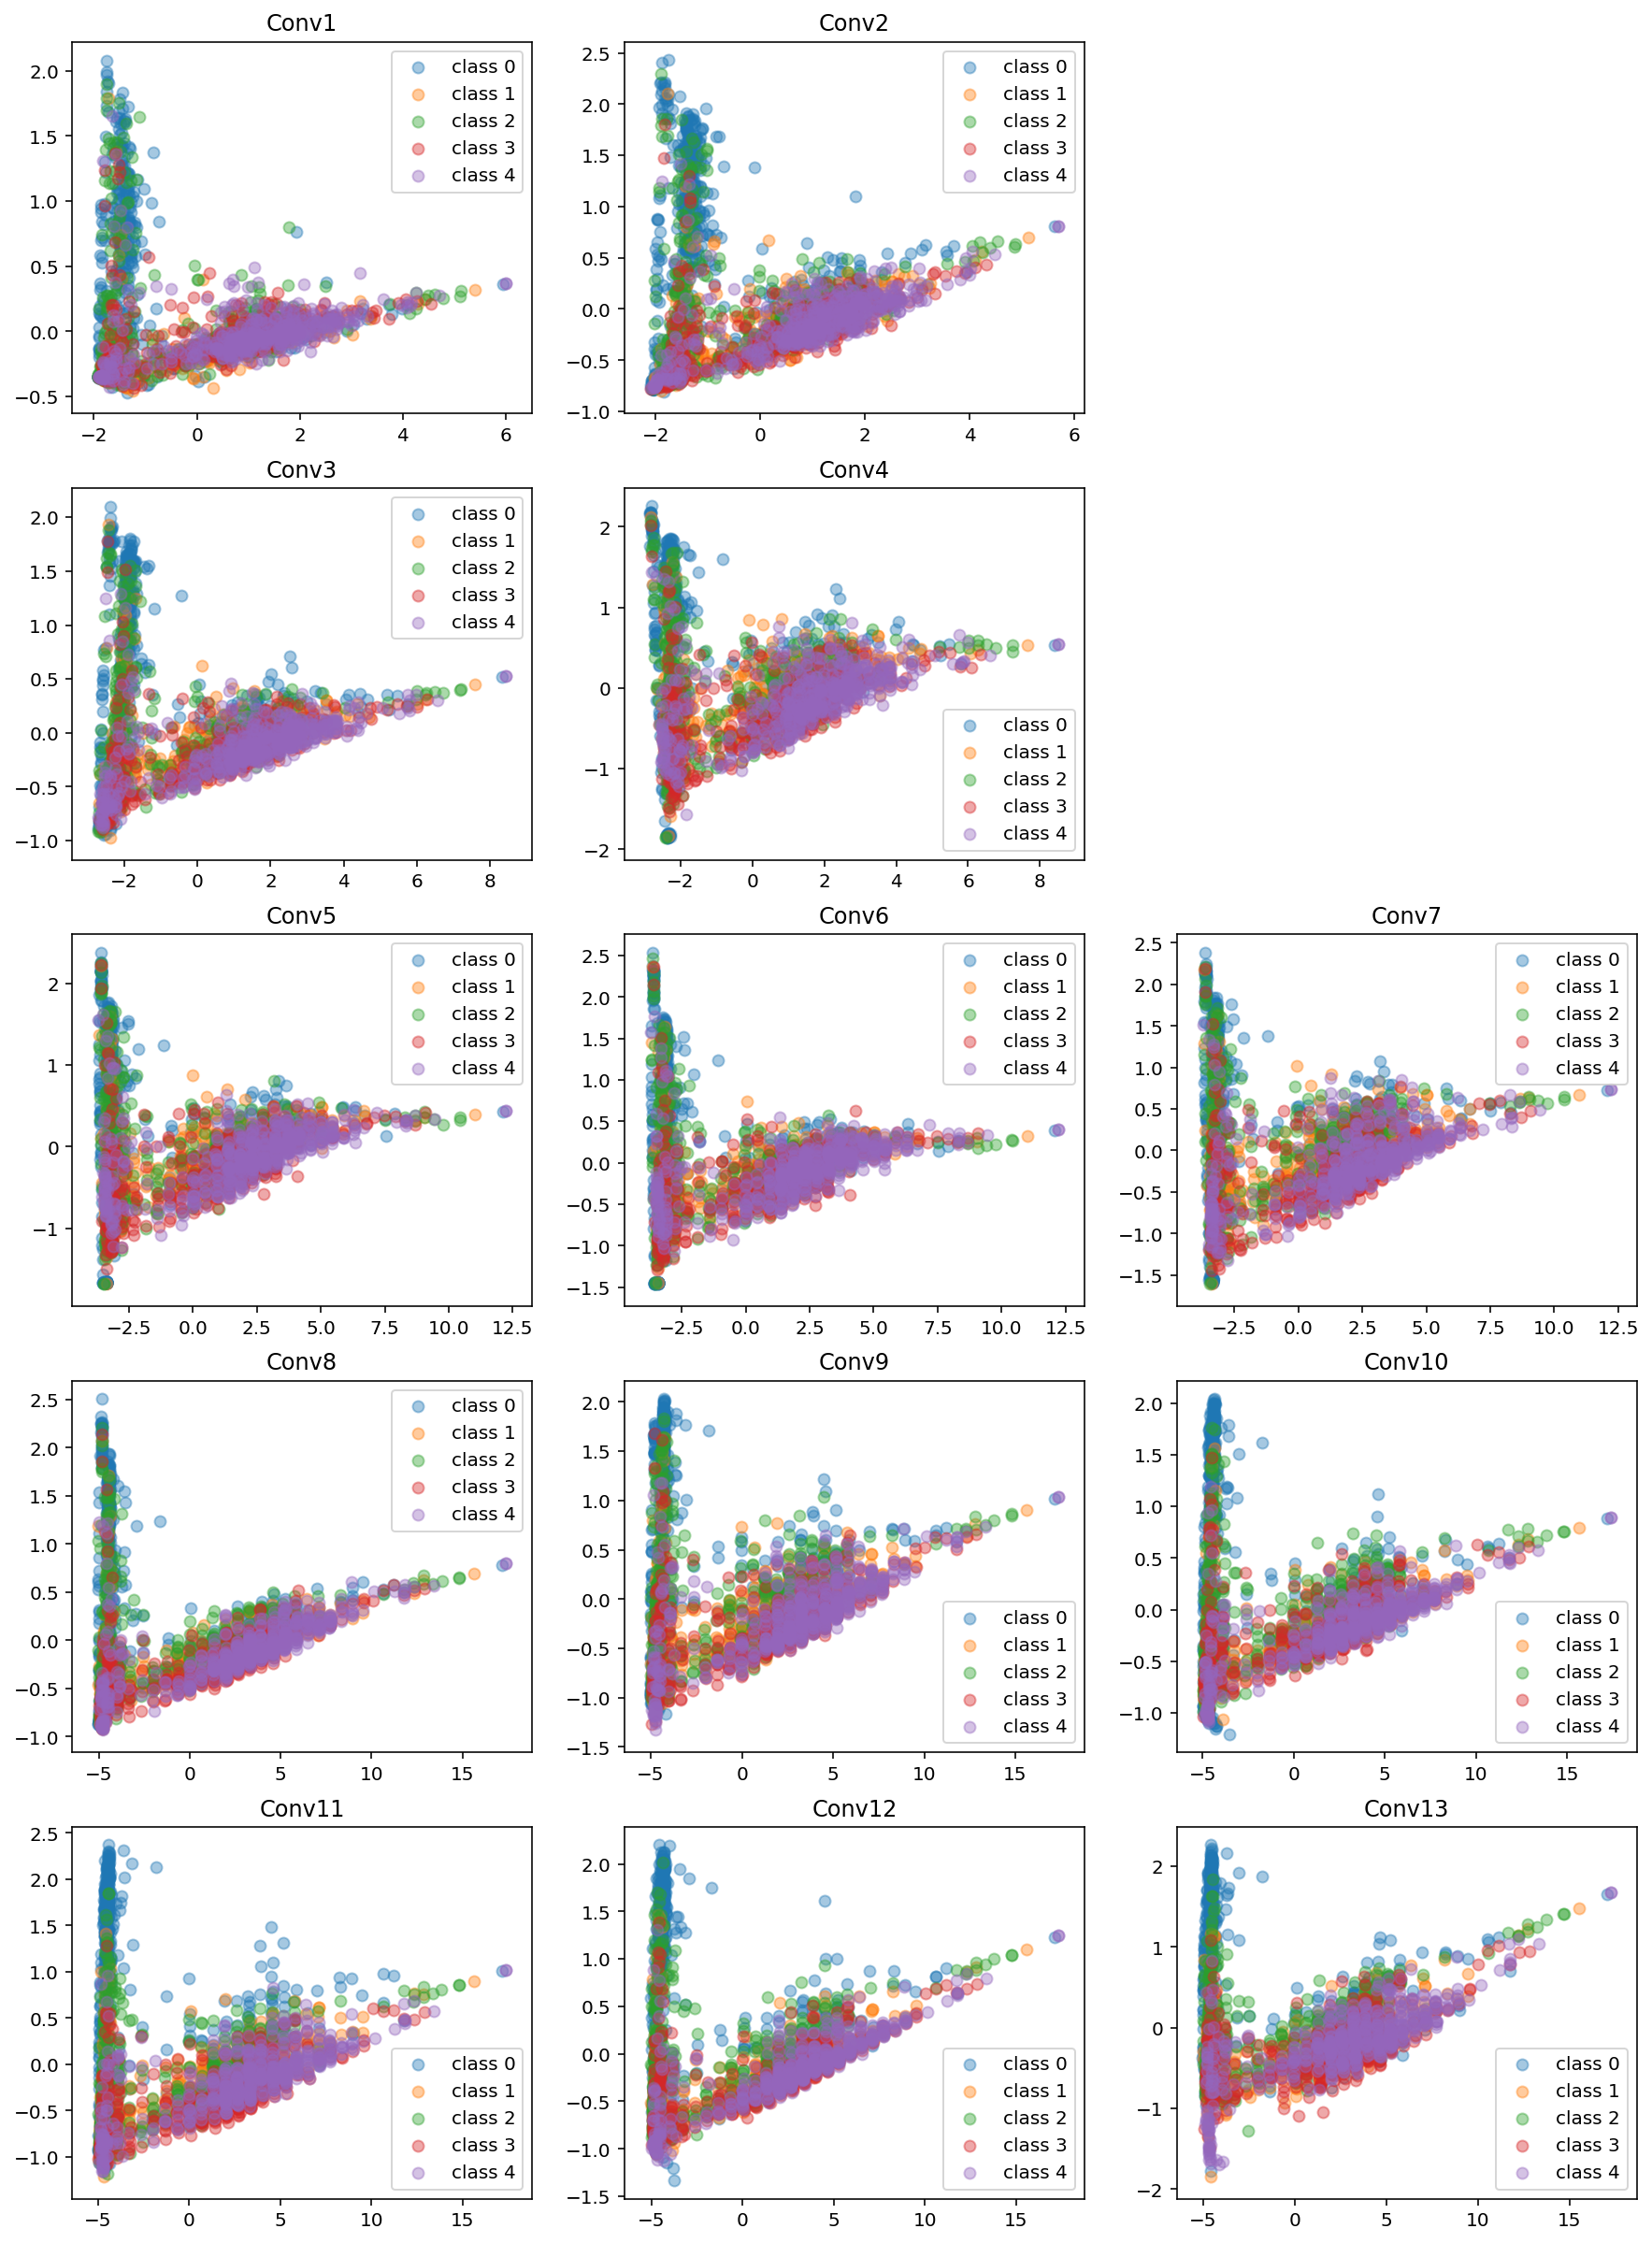

In [10]:
mapping = [1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.figure(figsize=(15, 5*6))
for i in range(1, 14):
    plt.subplot(7, 3, mapping[i-1])
    layer = "Conv{}".format(i)
    idx = layer2idx[layer]
    X = data[:, idx[0]:idx[1]]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    for label in classes:
        mask = (labels == label)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                alpha=0.4, label="class " + str(int(label)))
    plt.title(layer)
    plt.legend()

The results of visualization in each convolution layer are also disappointing.

## The Problem is Obvious!
Directly extracting CDRP models from the network trained in different dataset from where the samples come from seems not working.
The possible reasons are:
- Incorrect method of training gates:
    - The VGG on ImageNet-1000 output an 1000-dimension vector, the classification of labels is more fine-grained than the cifar-100. Some labels in cifar-100 is not presented in imagenet-1000, while some corresponds to multiple labels in imagenet-1000.
    - There is a constraint in the gate training: the output label should match the original prediction of the complete network for the sample, while such prediction might have no meaning at all.
    - We are trying to remove this constraint and investigate the result again.
- The clustering result SHOULD be such caotic, and the clustering is meaningless when we change the dataset.
    - The possible explaination for such situation might be that different dataset means different distribution of the data, and therefore make such feature analysis impossible. (But both Imagenet and Cifar-100 are for image classification)
- The clustering result SHOULD be such caotic, but there is adquate information for the assembly stage but we can not see from the plot.

We hope you could give us some advices on the reason of the problem and how to tackle it.